In [1]:
import boto3
import botocore
import sagemaker
import sys
import pandas as pd

In [31]:
bucket = 'scientist-13-jon'   # <--- specify a bucket you have access to
prefix = 'sagemaker/fraud'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://scientist-13-jon/sagemaker/fraud


In [66]:
df = pd.read_csv("fraud_reduced.csv")

In [67]:
df_orig = pd.read_csv("fraud_reduced.csv")

In [68]:
df_orig = df_orig[['isFraud']]

In [69]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [70]:
df = df.drop(columns=['step', 'isFraud', 'nameOrig', 'nameDest', 'isFraud'])

In [71]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0


In [72]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [73]:
df = pd.get_dummies(df, prefix=['type'], columns=['type'])

In [74]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [75]:
from sklearn.preprocessing import MinMaxScaler

In [76]:
amount_scaler = MinMaxScaler()
scaled_amt_df = amount_scaler.partial_fit(df[['amount']])

oldbalanceOrg_scaler = MinMaxScaler()
scaled_oldbalanceOrg_df = oldbalanceOrg_scaler.partial_fit(df[['oldbalanceOrg']])

newbalanceOrig_scaler = MinMaxScaler()
scaled_newbalanceOrig_df = newbalanceOrig_scaler.partial_fit(df[['newbalanceOrig']])

oldbalanceDest_scaler = MinMaxScaler()
scaled_oldbalanceDest_df = oldbalanceDest_scaler.partial_fit(df[['oldbalanceDest']])

newbalanceDest_scaler = MinMaxScaler()
scaled_newbalanceDest_df = newbalanceDest_scaler.partial_fit(df[['newbalanceDest']])

In [77]:
amt_scaled = scaled_amt_df.transform(df[['amount']])
oldbalanceOrg_scaled = scaled_oldbalanceOrg_df.transform(df[['oldbalanceOrg']])
newbalanceOrig_scaled = scaled_newbalanceOrig_df.transform(df[['newbalanceOrig']])
oldbalanceDest_scaled = scaled_oldbalanceDest_df.transform(df[['oldbalanceDest']])
newbalanceDest_scaled = scaled_newbalanceDest_df.transform(df[['newbalanceDest']])

In [78]:
df = df.assign(amt_scaled=pd.DataFrame(amt_scaled, columns=['amt_scaled']))
df = df.assign(oldbalanceOrg_scaled=pd.DataFrame(oldbalanceOrg_scaled, columns=['oldbalanceOrg']))
df = df.assign(newbalanceOrig_scaled=pd.DataFrame(newbalanceOrig_scaled, columns=['newbalanceOrig']))
df = df.assign(oldbalanceDest_scaled=pd.DataFrame(oldbalanceDest_scaled, columns=['oldbalanceDest']))
df = df.assign(newbalanceDest_scaled=pd.DataFrame(newbalanceDest_scaled, columns=['newbalanceDest']))

In [79]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0.000106,0.002855,0.003233,0.000000,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0.000020,0.000357,0.000391,0.000000,0.0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,0.000002,0.000003,0.000000,0.000000,0.0
3,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,0.000002,0.000003,0.000000,0.000059,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0.000126,0.000697,0.000603,0.000000,0.0


In [80]:
df = df.drop(columns=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])

In [81]:
df.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
0,0,0,0,1,0,0.000106,0.002855,0.003233,0.000000,0.0
1,0,0,0,1,0,0.000020,0.000357,0.000391,0.000000,0.0
2,0,0,0,0,1,0.000002,0.000003,0.000000,0.000000,0.0
3,0,1,0,0,0,0.000002,0.000003,0.000000,0.000059,0.0
4,0,0,0,1,0,0.000126,0.000697,0.000603,0.000000,0.0


Does it make sense to pass in df.isFraud? why only the single column?

The taxi data in the RCF example is only a single column. We need to add the whole dataset. 
https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

In [33]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
#rcf.fit(rcf.record_set(df.isFraud.as_matrix().reshape(-1,1)))
rcf.fit(rcf.record_set(df.as_matrix()))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-03-13-19-34-10-619


2019-03-13 19:34:11 Starting - Starting the training job...
2019-03-13 19:34:14 Starting - Launching requested ML instances......
2019-03-13 19:35:21 Starting - Preparing the instances for training......
2019-03-13 19:36:39 Downloading - Downloading input data......
2019-03-13 19:37:29 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[03/13/2019 19:37:32 INFO 140088377227072] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[03/13/2019 19:37:32 INFO 140088377227072] Reading provided configuration from /opt/ml/input/config/hyperp

[2019-03-13 19:37:44.142] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 10926, "num_examples": 6363, "num_bytes": 661712480}
[03/13/2019 19:37:44 INFO 140088377227072] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 10941.896200180054, "sum": 10941.896200180054, "min": 10941.896200180054}}, "EndTime": 1552505864.157736, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1552505853.202075}

[03/13/2019 19:37:44 INFO 140088377227072] Early stop condition met. Stopping training.
[03/13/2019 19:37:44 INFO 140088377227072] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 6363, "sum": 6363.0, "min": 6363}, "Number of Batches Since Last Reset": {"count": 1, "max": 6363, "sum": 6363.0, "min": 6363}, "Number of 

In [34]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-13-19-38-45-215
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-03-13-19-34-10-619


----------------------------------------------------------------------------!

In [35]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-03-13-19-34-10-619


In [82]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer


In [83]:
#df_numpy = df.isFraud.as_matrix().reshape(-1,1)
df_numpy = df.as_matrix()
print(df_numpy[:6])
results = rcf_inference.predict(df_numpy[:6])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 1.06437179e-04 2.85534757e-03 3.23275647e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 2.01662565e-05 3.56616357e-04 3.90938877e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 1.95790998e-06 3.03767521e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.95790998e-06 3.03767521e-06 0.00000000e+00
  5.94973445e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 1.26216397e-04 6.97389810e-04 6.02719283e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 8.45655937e-05 9.03918159e-04 9.28552032e-04
  0.00000000e+00 0.00000000e+00]]


I was getting timeout errors running the predictions against the 6million rows, so let's do a subset

In [84]:
samples = 6000
df_numpy = df_numpy[:samples]
df_small = df[:samples]
df_orig = df_orig[:samples]

In [85]:
results = rcf_inference.predict(df_numpy)
scores = [datum['score'] for datum in results['scores']]

With each data point, RCF associates an anomaly score. Low score values indicate that the data point is considered "normal." High values indicate the presence of an anomaly in the data. The definitions of "low" and "high" depend on the application but common practice suggests that scores beyond three standard deviations from the mean score are considered anomalous.

From: https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html

In [86]:
#scores

In [87]:
# add scores to taxi data frame and print first few values
df_small['score'] = pd.Series(scores, index=df_small.index)
df_small.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled,score
0,0,0,0,1,0,0.000106,0.002855,0.003233,0.000000,0.0,0.796397
1,0,0,0,1,0,0.000020,0.000357,0.000391,0.000000,0.0,0.616194
2,0,0,0,0,1,0.000002,0.000003,0.000000,0.000000,0.0,0.870301
3,0,1,0,0,0,0.000002,0.000003,0.000000,0.000059,0.0,0.611575
4,0,0,0,1,0,0.000126,0.000697,0.000603,0.000000,0.0,0.641780


In [88]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100


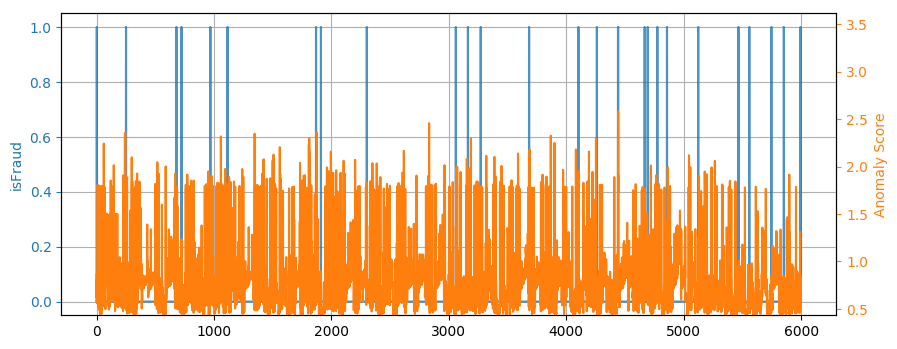

In [89]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df_small)
#start, end = 5500, 6500
df_subset = df_small[start:end]

ax1.plot(df_orig['isFraud'], color='C0', alpha=0.8)
ax2.plot(df_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('isFraud', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [ ]:
# Delete the endpoint when finished
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint)